**Baseline for AI Art Classification**

This notebook fine-tunes a pretrained **ResNet50** model for AI vs. human art classification. It automates dataset setup from [Kaggle](https://www.kaggle.com/datasets/doctorstrange420/real-and-fake-ai-generated-art-images-dataset), creates a custom train/validation/test split, and applies standard image transformations. The model is trained using **PyTorch** with **Adam optimization** and evaluated using **accuracy**, **confusion matrix**, and **classification reports**. Finally, **Grad-CAM visualizations** are generated to highlight image regions influencing the model’s decisions.

Mount drive and get Kaggle API key

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Copy kaggle.json to the hidden kaggle folder
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Deep_Learning_Final_Project/notebooks/kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


Download and unzip Kaggle dataset

In [ ]:
!kaggle datasets download -d kausthubkannan/ai-and-human-art-classification
!unzip -q ai-and-human-art-classification.zip -d data/
!ls data/ai_art_classification

Dataset URL: https://www.kaggle.com/datasets/kausthubkannan/ai-and-human-art-classification
License(s): DbCL-1.0
 99% 2.19G/2.21G [00:28<00:00, 206MB/s]
100% 2.21G/2.21G [00:28<00:00, 83.4MB/s]
test  train


Make sure we are using GPU

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: Tesla T4


Create our own train/val/test split

In [ ]:
import os, shutil, random

base_dir = "data/ai_art_classification/train"
new_base = "data/ai_art_split"

# create new structure
for split in ["train", "val", "test"]:
    for cls in ["AI_GENERATED", "NON_AI_GENERATED"]:
        os.makedirs(os.path.join(new_base, split, cls), exist_ok=True)

# split ratios
split_ratios = {'train': 0.7, 'val': 0.15, 'test': 0.15}
random.seed(42)

for cls in ["AI_GENERATED", "NON_AI_GENERATED"]:
    src_dir = os.path.join(base_dir, cls)
    all_imgs = os.listdir(src_dir)
    random.shuffle(all_imgs)
    n = len(all_imgs)

    train_cut = int(split_ratios['train'] * n)
    val_cut = int(split_ratios['val'] * n)

    splits = {
        'train': all_imgs[:train_cut],
        'val': all_imgs[train_cut:train_cut + val_cut],
        'test': all_imgs[train_cut + val_cut:]
    }

    for split, files in splits.items():
        dest = os.path.join(new_base, split, cls)
        for f in files:
            shutil.copy(os.path.join(src_dir, f), os.path.join(dest, f))

print("✅ Done splitting into train/val/test folders!")

✅ Done splitting into train/val/test folders!


Load dataset with PyTorch

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_tfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
test_tfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_ds = datasets.ImageFolder("data/ai_art_split/train", transform=train_tfms)
val_ds   = datasets.ImageFolder("data/ai_art_split/val", transform=test_tfms)
test_ds  = datasets.ImageFolder("data/ai_art_split/test", transform=test_tfms)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=32)
test_dl  = DataLoader(test_ds, batch_size=32)

print(train_ds.classes)
print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

['AI_GENERATED', 'NON_AI_GENERATED']
Train: 13031 | Val: 2792 | Test: 2795


Display some sample images from dataset we loaded

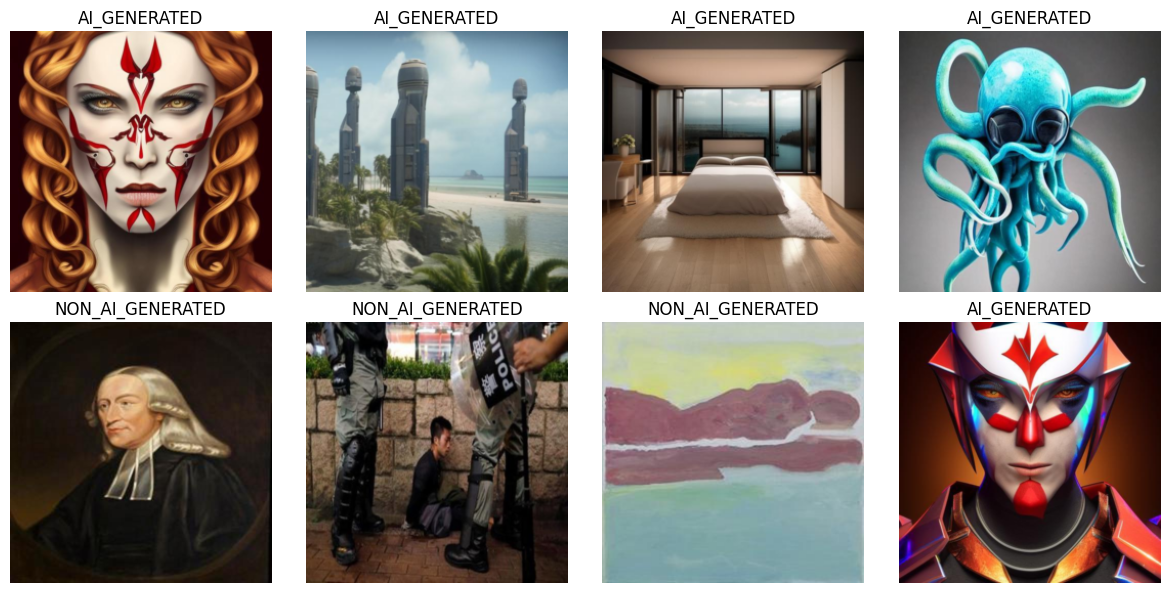

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def denorm(img_tensor):
    img_tensor = img_tensor * 0.5 + 0.5  # reverse normalization
    return np.clip(img_tensor.permute(1, 2, 0).numpy(), 0, 1)

# get one batch of images
images, labels = next(iter(train_dl))
classes = train_ds.classes

plt.figure(figsize=(12, 6))
for i in range(8):  # show 8 sample images
    plt.subplot(2, 4, i+1)
    plt.imshow(denorm(images[i]))
    plt.title(classes[labels[i].item()])
    plt.axis('off')
plt.tight_layout()
plt.show()

Train a baseline classifier (ResNet50)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = timm.create_model('resnet50', pretrained=True, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Training and validation loop

In [ ]:
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_dl)

    # validation accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            pred = out.argmax(1)
            correct += (pred==yb).sum().item()
            total += yb.size(0)
    acc = correct / total
    print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Val Accuracy: {acc:.2%}")

Epoch 1 | Train Loss: 0.3239 | Val Accuracy: 93.41%
Epoch 2 | Train Loss: 0.1455 | Val Accuracy: 95.20%
Epoch 3 | Train Loss: 0.1019 | Val Accuracy: 95.24%
Epoch 4 | Train Loss: 0.0662 | Val Accuracy: 95.85%
Epoch 5 | Train Loss: 0.0446 | Val Accuracy: 95.56%


Evaluate on test set

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        preds = out.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=train_ds.classes))

[[1482   69]
 [  69 1175]]
                  precision    recall  f1-score   support

    AI_GENERATED       0.96      0.96      0.96      1551
NON_AI_GENERATED       0.94      0.94      0.94      1244

        accuracy                           0.95      2795
       macro avg       0.95      0.95      0.95      2795
    weighted avg       0.95      0.95      0.95      2795



Grad-CAM

In [ ]:
!pip install grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


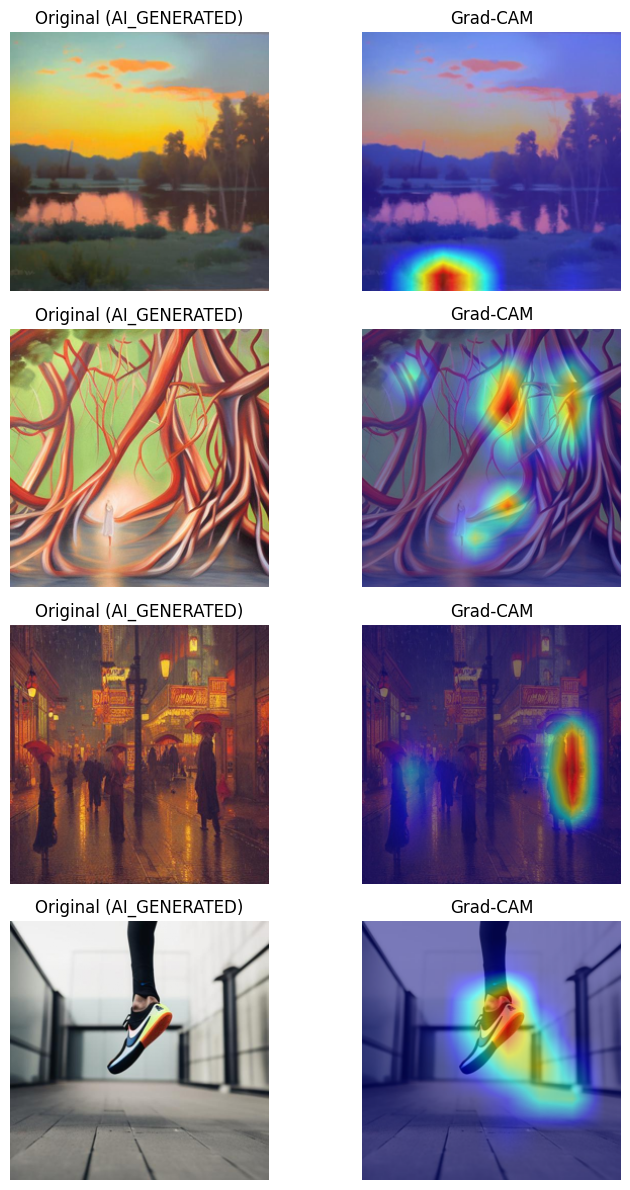

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch

# pick the final convolutional block in ResNet50
target_layer = model.layer4[-1]

# initialize GradCAM (no use_cuda arg anymore)
cam = GradCAM(model=model, target_layers=[target_layer])

# same normalization as training
gradcam_tfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

num_samples = 4
fig, axs = plt.subplots(num_samples, 2, figsize=(8, num_samples*3))

for i in range(num_samples):
    img_path, label = test_ds.samples[i]
    rgb_img = np.array(Image.open(img_path).convert('RGB').resize((256,256))) / 255.0
    input_tensor = gradcam_tfms(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)

    # Grad-CAM for true class
    targets = [ClassifierOutputTarget(label)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets, eigen_smooth=True)[0, :]

    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    axs[i, 0].imshow(rgb_img)
    axs[i, 0].set_title(f"Original ({train_ds.classes[label]})")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(cam_image)
    axs[i, 1].set_title("Grad-CAM")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()